In [1]:
from tqdm import tqdm

import torch
from torch import nn
import numpy as np

In [2]:
x1 = x2 = np.arange(1, 31)

In [3]:
x1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [4]:
x2

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [5]:
x12 = np.array(np.meshgrid(x1, x2)).T.reshape(-1,2,1)

In [6]:
x12.shape

(900, 2, 1)

In [7]:
y = np.prod(x12, axis = -2)

In [8]:
y.shape

(900, 1)

In [9]:
repeat = 3
epoch = 25000

In [10]:
class PESymetryMean(nn.Module):
    def __init__(self, in_dim: int, out_dim: int) -> None:
        super(PESymetryMean, self).__init__()
        self.diagonal = nn.Linear(in_dim, out_dim)
        self.rest = nn.Linear(in_dim, out_dim, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x_mean = x.mean(0, keepdim=True)
        x_mean = x.mean(-2, keepdim=True)
        x_mean = self.rest(x_mean)
        x = self.diagonal(x)
        x = x + x_mean
        return x

In [11]:
class PESymetryMax(nn.Module):
    def __init__(self, in_dim: int, out_dim: int) -> None:
        super(PESymetryMax, self).__init__()
        self.diagonal = nn.Linear(in_dim, out_dim)
        self.rest = nn.Linear(in_dim, out_dim, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_max, _ = x.max(0, keepdim=True)
        x_max = self.rest(x_max)
        x = self.diagonal(x)
        x = x + x_max
        return x

In [12]:
class PESymetrySum(nn.Module):
    def __init__(self, in_dim: int, out_dim: int) -> None:
        super(PESymetrySum, self).__init__()
        self.diagonal = nn.Linear(in_dim, out_dim)
        self.rest = nn.Linear(in_dim, out_dim, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_mean = x.sum(-2, keepdim=True)
        x_mean = self.rest(x_mean)
        x = self.diagonal(x)
        x = x + x_mean
        return x

In [13]:
class PINNMeanM(nn.Module):
    def __init__(self):
        super(PINNMeanM, self).__init__()
        input_dim = 1
        inter_dim = 32
        final_dim = 1
        pe_layers = [
            PESymetryMean(input_dim, inter_dim),
            nn.ELU(),
            PESymetryMean(inter_dim, inter_dim),
            nn.ELU(),
            PESymetryMean(inter_dim, inter_dim),
            nn.ELU(),
            PESymetryMean(inter_dim, final_dim),
            nn.ELU(),
        ]

        self.pe_net = nn.Sequential(*pe_layers)
        
        self.MseLoss = nn.MSELoss()
        self.optimizer = torch.optim.Adam([
            {'params': self.pe_net.parameters(), 'lr': 0.003},
        ])
    
    def forward(self, x):
        temp_x = self.pe_net(x)
        final_x = temp_x.mean(-2)
        return final_x
    
    def update(self, y, target_y):
        loss = self.MseLoss(y, target_y)
        
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()
        
        return loss.item()

In [14]:
class PINNMeanS(nn.Module):
    def __init__(self):
        super(PINNMeanS, self).__init__()
        input_dim = 1
        inter_dim = 32
        final_dim = 1
        pe_layers = [
            PESymetryMean(input_dim, inter_dim),
            nn.ELU(),
            PESymetryMean(inter_dim, inter_dim),
            nn.ELU(),
            PESymetryMean(inter_dim, inter_dim),
            nn.ELU(),
            PESymetryMean(inter_dim, final_dim),
            nn.ELU(),
        ]

        self.pe_net = nn.Sequential(*pe_layers)
        
        self.MseLoss = nn.MSELoss()
        self.optimizer = torch.optim.Adam([
            {'params': self.pe_net.parameters(), 'lr': 0.003},
        ])
    
    def forward(self, x):
        temp_x = self.pe_net(x)
        final_x = temp_x.sum(-2)
        return final_x
    
    def update(self, y, target_y):
        loss = self.MseLoss(y, target_y)
        
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()
        
        return loss.item()

In [15]:
class DeepSetLin(nn.Module):
    def __init__(self):
        super(DeepSetLin, self).__init__()
        input_dim = 1
        inter_dim = 32
        final_dim = 1
        pe_layers = [
            nn.Linear(input_dim, inter_dim),
            nn.ELU(),
            nn.Linear(inter_dim, inter_dim),
            nn.ELU(),
            nn.Linear(inter_dim, inter_dim),
            nn.ELU(),
        ]
        pi_layers = [
            nn.Linear(inter_dim, final_dim),
            nn.ELU(),
            
        ]
        self.pe_net = nn.Sequential(*pe_layers)
        self.pi_net = nn.Sequential(*pi_layers)
        
        self.MseLoss = nn.MSELoss()
        self.optimizer = torch.optim.Adam([
            {'params': self.pe_net.parameters(), 'lr': 0.003},
            {'params': self.pi_net.parameters(), 'lr': 0.003}
        ])
    
    def forward(self, x):
        temp_x = self.pe_net(x)
        final_x = self.pi_net(temp_x.sum(-2))
        return final_x
    
    def update(self, y, target_y):
        loss = self.MseLoss(y, target_y)
        
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()
        
        return loss.item()

In [16]:
result_pinnmeanm = []

for _ in (range(repeat)):
    pinnmeanm = PINNMeanM()
    for e in tqdm(range(epoch)):
        y_p = pinnmeanm(torch.tensor(x12, dtype=torch.float32))
        y = torch.tensor(y, dtype=torch.float32)
        loss = pinnmeanm.update(y_p, y)
        result_pinnmeanm.append({"model":"IPENN(Mean)", "epoch":e, "loss":loss})

  0%|                                                 | 0/25000 [00:00<?, ?it/s]/var/folders/9r/svf227552bj3rl_tdhz9zdm00000gp/T/ipykernel_88733/2060461734.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
100%|█████████████████████████████████████| 25000/25000 [08:33<00:00, 48.72it/s]


In [17]:
result_pinnmeans = []

for _ in (range(repeat)):
    pinnmeans = PINNMeanS()
    for e in tqdm(range(epoch)):
        y_p = pinnmeans(torch.tensor(x12, dtype=torch.float32))
        y = torch.tensor(y, dtype=torch.float32)
        loss = pinnmeans.update(y_p, y)
        result_pinnmeans.append({"model":"IPENN(Sum)", "epoch":e, "loss":loss})

  0%|                                                 | 0/25000 [00:00<?, ?it/s]/var/folders/9r/svf227552bj3rl_tdhz9zdm00000gp/T/ipykernel_88733/1326666298.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
100%|█████████████████████████████████████| 25000/25000 [07:24<00:00, 56.25it/s]


In [18]:
result_deepsetlin = []

for _ in (range(repeat)):
    deepsetlin = DeepSetLin()
    for e in tqdm(range(epoch)):
        y_p = deepsetlin(torch.tensor(x12, dtype=torch.float32))
        y = torch.tensor(y, dtype=torch.float32)
        loss = deepsetlin.update(y_p, y)
        result_deepsetlin.append({"model":"DeepSet", "epoch":e, "loss":loss})

  0%|                                                 | 0/25000 [00:00<?, ?it/s]/var/folders/9r/svf227552bj3rl_tdhz9zdm00000gp/T/ipykernel_88733/2045018654.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
100%|████████████████████████████████████| 25000/25000 [02:10<00:00, 191.57it/s]


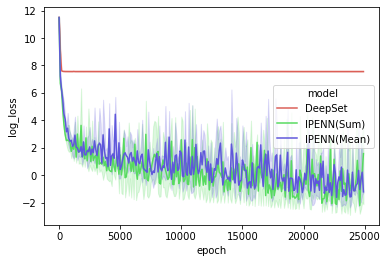

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results = []
results = result_deepsetlin + result_pinnmeans + result_pinnmeanm 
df = pd.DataFrame(results)
df["log_loss"] = np.log(df["loss"])
df = df[df["epoch"]%100 == 0]

plt.clf()

loss_plot = sns.lineplot(data=df, x="epoch", y="log_loss", hue="model", 
#                          hue_order=["IPENN(Sum)", "IPENN(Mean)", "DeepSet"], 
                         palette="hls",)

In [20]:
loss_plot.figure.savefig(f"PI_Toy_ECML.png", bbox_inches="tight", facecolor=(1,1,1,0), dpi=500,)